In [23]:
import tensorflow as tf
import tensorflow.keras
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### 데이터 다운로드

In [4]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seokju2","key":"04eb776a70c8fa05e8e39085c8bab7e5"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# permmision warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [6]:

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
#!kaggle datasets download -d tongpython/cat-and-dog
!unzip chest-xray-pneumonia.zip -d chest/
data_dir = './chest/'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: chest/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest/chest_xray/train/NORMAL/IM-0446-0001.j

### 데이터 적재

In [7]:
train_normal =glob.glob(data_dir + '/chest_xray/train/NORMAL/*.jpeg')
train_Pneumonia =glob.glob(data_dir + '/chest_xray/train/PNEUMONIA/*.jpeg')

test_normal =glob.glob(data_dir + '/chest_xray/test/NORMAL/*.jpeg')
test_Pneumonia =glob.glob(data_dir + '/chest_xray/test/PNEUMONIA/*.jpeg')

In [8]:
print(len(train_normal), len(train_Pneumonia))
print(len(test_normal), len(test_Pneumonia))

1341 3875
234 390


### 데이터 시각화

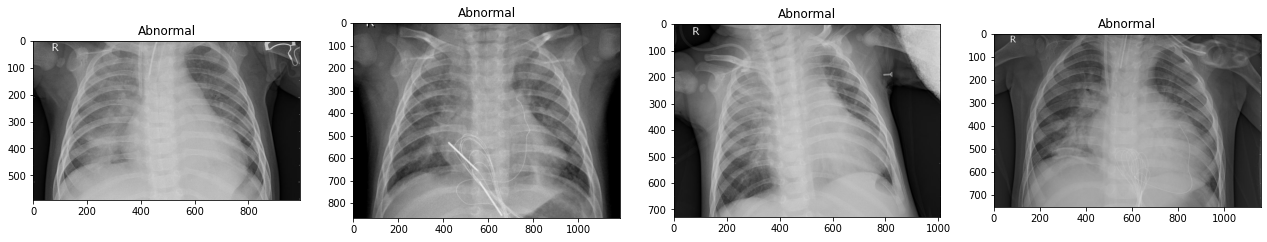

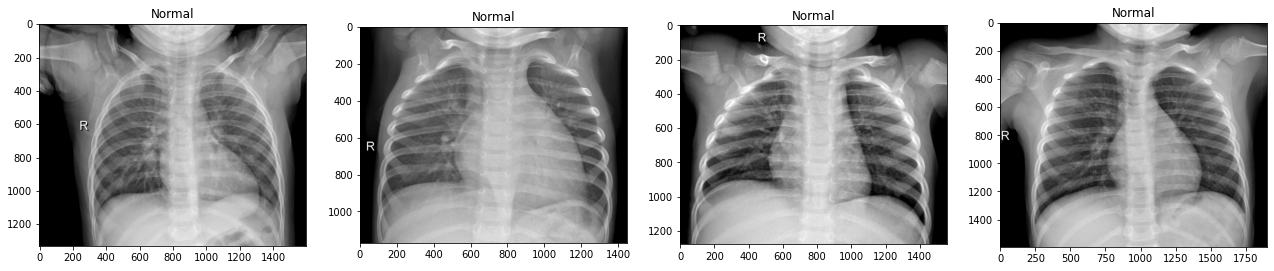

In [29]:
figure, axes = plt.subplots(figsize=(22, 6), nrows=1, ncols=4)

dog_filepaths = train_Pneumonia[:4]

for i in range(4):
    dog_image = cv2.cvtColor(cv2.imread(dog_filepaths[i]), cv2.COLOR_BGR2RGB)
    axes[i].set_title("Abnormal")
    axes[i].imshow(dog_image)
    
figure, axes = plt.subplots(figsize=(22, 6), nrows=1, ncols=4)

normal_filepaths = train_normal[:4]

for i in range(4):
    normal_image = cv2.cvtColor(cv2.imread(normal_filepaths[i]), cv2.COLOR_BGR2RGB)
    axes[i].set_title("Normal")
    axes[i].imshow(normal_image)
    

### 데이터 전처리 (using "from dataframe")

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split


# train_df
train_path = train_normal + train_Pneumonia # 4000 4005 (normal/Pneumonia)
train_label = ["NORMAL" for _ in range(len(train_normal))] + ["Pneumonia" for _ in range(len(train_Pneumonia))]
train_df = pd.DataFrame({"path":train_path, "label":train_label})


# test_df
test_paths = test_normal + test_Pneumonia # 1011 1012 (Cat/Pneumonia)
test_label = ["normal" for _ in range(len(test_normal))] + ["Pneumonia" for _ in range(len(test_Pneumonia))]
test_df = pd.DataFrame({"path":test_paths, "label":test_label})

# valid_df
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

print(train_df['label'].value_counts())
print(valid_df['label'].value_counts())

DOG    3099
CAT    1073
Name: label, dtype: int64
DOG    776
CAT    268
Name: label, dtype: int64


In [11]:
pd.set_option("display.max_colwidth", 200)
train_df.head()

,path,label
99,./chest//chest_xray/train/NORMAL/NORMAL2-IM-1219-0001.jpeg,CAT
1284,./chest//chest_xray/train/NORMAL/NORMAL2-IM-0673-0001.jpeg,CAT
5142,./chest//chest_xray/train/PNEUMONIA/person445_bacteria_1928.jpeg,DOG
1365,./chest//chest_xray/train/PNEUMONIA/person7_bacteria_29.jpeg,DOG
2649,./chest//chest_xray/train/PNEUMONIA/person453_virus_936.jpeg,DOG


In [12]:
BATCH_SIZE = 64
# train_generator
train_generator = ImageDataGenerator(horizontal_flip=True,
                                    rotation_range = 20, 
                                    rescale = 1/255.0
                                    ) # 다양한 Augmentation 시도해보기!!!
train_generator_iterator = train_generator.flow_from_dataframe(dataframe=train_df,
                                                               x_col = 'path',
                                                               y_col = 'label',
                                                               target_size = (224, 224), class_mode = "binary",
                                                               batch_size = BATCH_SIZE, shuffle=True)

# valid_generator
valid_generator = ImageDataGenerator(rescale = 1/255.0)

valid_generator_iterator = valid_generator.flow_from_dataframe(dataframe=valid_df,
                                                               x_col = 'path',
                                                               y_col = 'label',
                                                               target_size = (224, 224), class_mode = "binary",
                                                               batch_size = BATCH_SIZE, shuffle=False)


# test_generator
test_generator = ImageDataGenerator(rescale = 1/255.0)

test_generator_iterator = test_generator.flow_from_dataframe(dataframe=test_df,
                                                               x_col = 'path',
                                                               y_col = 'label',
                                                               target_size = (224, 224), class_mode = "binary",
                                                               batch_size = BATCH_SIZE, shuffle=False)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [13]:
train_batch, label_batch = next(train_generator_iterator)
train_batch.shape, label_batch.shape

((64, 224, 224, 3), (64,))

### 모델 생성 및 학습

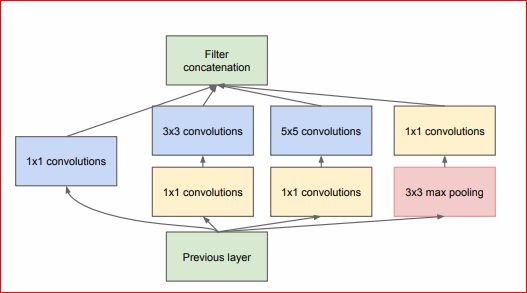

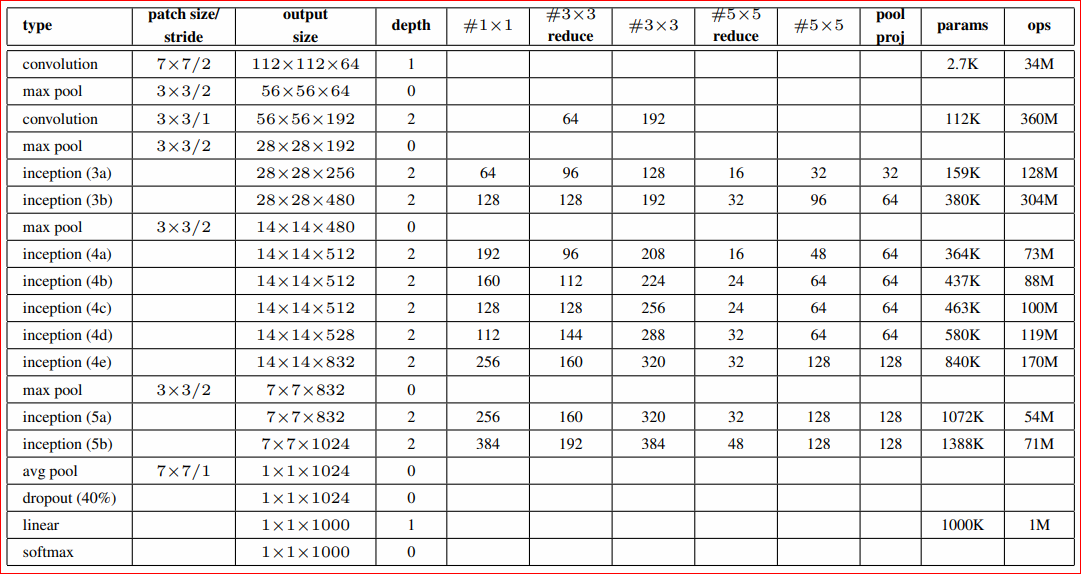

In [14]:
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool, name ):
    # 1X1 Conv
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding="same", activation="relu")(x)

    # 3X3 적용전 1X1 Conv
    reduce_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding="same", activation="relu")(x)
    # 3X3 Conv
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding="same", activation="relu")(reduce_3x3)

    # 5X5 적용전 1X1 Conv
    reduce_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding="same", activation="relu")(x)
    # 5X5 Conv
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding="same", activation="relu")(reduce_5x5)

    # Max Pooling Proj.
    pool = MaxPooling2D((3,3), strides=(1,1), padding="same")(x)
    pool_proj = Conv2D(filters_pool, (1, 1), padding="same", activation="relu")(pool)

    # Concatenate
    # (batch(axis=0), height(axis=1), width(axis=2), depth(axis=3))
    output = Concatenate(axis=-1, name=name)([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    
    return output

In [15]:
IMAGE_SIZE = 224

def build_GoogLeNet():
    tf.keras.backend.clear_session()
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    x = Conv2D(filters=64, kernel_size=(7, 7), padding="same", strides=(2, 2), activation="relu")(input_tensor)
    x = MaxPooling2D(pool_size=(3, 3), padding="same", strides=(2, 2))(x)
    x = Conv2D(filters=64, kernel_size=(1, 1), padding="same", strides=(1, 1), activation="relu")(x)
    x = Conv2D(filters=192, kernel_size=(3, 3), padding="same", strides=(1, 1), activation="relu")(x)
    x = MaxPooling2D(pool_size=(3, 3), padding="same", strides=(2, 2))(x)
    
    # 인셉션 모듈 3a
    x = inception_module(x, 64, 96, 128, 16, 32, 32, name="inception_3a")
    # 인셉션 모듈 3b
    x = inception_module(x, 128, 128, 192, 32, 96, 64, name="inception_3b")

    x = MaxPooling2D(pool_size=(3, 3), padding="same", strides=(2, 2))(x)

    # 인셉션 모듈 4a
    x = inception_module(x, 192, 96, 208, 16, 48, 64, "inception_4a")
    # 인셉션 모듈 4b
    x = inception_module(x, 160, 112, 224, 24, 64, 64, name="inception_4b")
    # 인셉션 모듈 4c
    x = inception_module(x, 128, 128, 256, 24, 64, 64, name="inception_4c")
    # 인셉션 모듈 4d
    x = inception_module(x, 112, 144, 288, 32, 64, 64, name="inception_4d")
    # 인셉션 모듈 4e
    x = inception_module(x, 256, 160, 320, 32, 128, 128, name="inception_4e")

    x = MaxPooling2D(pool_size=(3, 3), padding="same", strides=(2, 2))(x)

    # 인셉션 모듈 5a
    x = inception_module(x, 256, 160, 320, 32, 128, 128, name="inception_5a")
    # 인셉션 모듈 5b
    x = inception_module(x, 384, 192, 384, 48, 128, 128, name="inception_5b")

    x = GlobalAveragePooling2D()(x) 
    x = Dropout(0.4)(x)    
    output = Dense(units=1, activation='sigmoid')(x)


    model = Model(inputs=input_tensor, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'] )
    return model

model = build_GoogLeNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
                                                                                              

In [16]:
import os
import time
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
  run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
  return os.path.join(root_logdir, run_id)

In [17]:
run_logdir = get_run_logdir()
checkpoint_cb = ModelCheckpoint("my_best_model.h5", monitor="val_loss", save_best_only = True, verbose=1)
early_stopping_cb = EarlyStopping( monitor="val_loss", patience=15, verbose=1, restore_best_weights=False)
reduce_lr_cb = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1)
tensorboard_cb = TensorBoard(run_logdir)

In [18]:
history = model.fit(train_generator_iterator, validation_data=valid_generator_iterator, epochs=40, 
                    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb, tensorboard_cb])

Epoch 1/40
66/66 [==============================] - ETA: 0s - loss: 0.5916 - accuracy: 0.7421
Epoch 1: val_loss improved from inf to 0.58489, saving model to my_best_model.h5
66/66 [==============================] - 121s 2s/step - loss: 0.5916 - accuracy: 0.7421 - val_loss: 0.5849 - val_accuracy: 0.7433 - lr: 1.0000e-04
Epoch 2/40
66/66 [==============================] - ETA: 0s - loss: 0.5551 - accuracy: 0.7428
Epoch 2: val_loss improved from 0.58489 to 0.42383, saving model to my_best_model.h5
66/66 [==============================] - 94s 1s/step - loss: 0.5551 - accuracy: 0.7428 - val_loss: 0.4238 - val_accuracy: 0.7433 - lr: 1.0000e-04
Epoch 3/40
66/66 [==============================] - ETA: 0s - loss: 0.3938 - accuracy: 0.8169
Epoch 3: val_loss improved from 0.42383 to 0.27118, saving model to my_best_model.h5
66/66 [==============================] - 93s 1s/step - loss: 0.3938 - accuracy: 0.8169 - val_loss: 0.2712 - val_accuracy: 0.8851 - lr: 1.0000e-04
Epoch 4/40
66/66 [==========

### 모델 평가

In [19]:
model.evaluate(test_generator_iterator)

10/10 [==============================] - 7s 639ms/step - loss: 0.5786 - accuracy: 0.8157


[0.5785531997680664, 0.8157051205635071]

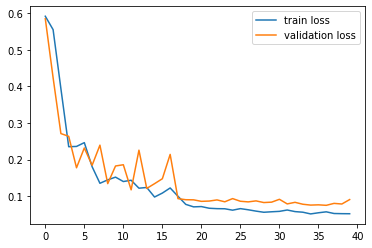

In [20]:
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()

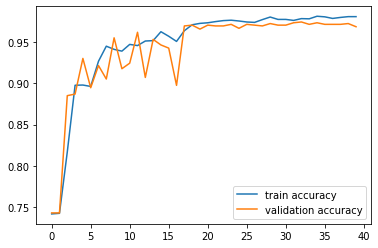

In [21]:
plt.plot(history.history['accuracy'], label="train accuracy")
plt.plot(history.history['val_accuracy'], label="validation accuracy")
plt.legend()

In [22]:
%load_ext tensorboard 
%tensorboard --logdir=./my_logs --port=6006

ModuleNotFoundError: ignored